# Optimizer Code

In [1]:
import quantities as pq
import pandas as pd
from olfactometer.plottingMultiDim import plotterDim 
import math
import datetime
from collections import deque
import numpy as np
from collections import OrderedDict
from scipy.optimize import minimize, least_squares, rosen_der, newton, approx_fprime, newton_krylov, root, fmin_l_bfgs_b, \
                            fmin_tnc, fmin_slsqp, fmin_cobyla, fmin_bfgs, fmin_cg, shgo, differential_evolution, basinhopping, fmin

from olfactometer.equipment import AirSupply, YConnector, Mask, Olfactometer
from olfactometer.my_equipment import MyManifold, MyValve, MyJar, MyLowMFC, \
                                      MyMediumMFC, MyHighMFC, PTFETube, StiffTube, \
                                      STUB_LENGTH
from olfactometer.odorants import Solution, Compound, ChemicalOrder, \
                                  Vendor, Molecule
from autograd import grad, jacobian
from numdifftools import Jacobian, Hessian

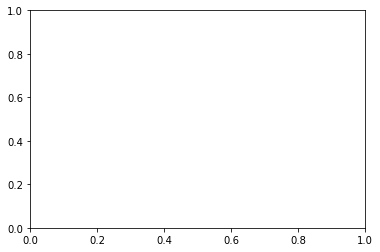

In [2]:
grapher = plotterDim()

In [13]:
from scipy import optimize
import autograd as ag

def jac_old(x, u):
    J = np.empty((u.size, x.size))
    den = u ** 2 + x[2] * u + x[3]
    num = u ** 2 + x[1] * u
    J[:, 0] = num / den
    J[:, 1] = x[0] * u / den
    J[:, 2] = -x[0] * num * u / den ** 2
    J[:, 3] = -x[0] * num / den ** 2
    return J

def hess(_,x): # Computed with sympy
    return np.array(((1 - 4*x[1] + 12*x[0]**2, -4*x[0]), (-4*x[0], 2)))

def rosen_hess(x, _):
    x=x[0]
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

def rosen_der(x,_):
    x=x[0]
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

def residuals(variables, x, n_jars=10):
        """
        wNA: The fraction of time that valve N is in state A
        wNB: The fraction of the remaining time that valve N is in state B
        fA: The flow rate through MFC A
        fB: The flow rate through MFC B
        """
        total_vapor = np.array([0.00184084, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        #print(f"What you got {variables} and {x}")
        # Unpack variables
        wA = variables[:n_jars]
        wB = variables[n_jars:(n_jars*2)]
        fA,fB = variables[(n_jars*2):]
        # Convert fraction-of-remaining time values (w1B, w2B, ...)
        # to absolute fractions
        wB = (1-wA)*wB        
        fA = fA * 999.9999999999998
        fB = fB * 10.0
        # Pre-compute sums for efficiency
        wAs = wA.sum()
        wBs = wB.sum()
        if (wAs == 0): wAs=1e-20
        if (wBs == 0): wBs=1e-20
        # The residuals whose sum of squares will be minimized
        residuals = [fA*wA[i]/wAs + fB*wB[i]/wBs - x[i] for i in range(n_jars)
                     if total_vapor[i]]
        # Try to sparsen the solution by penalizing the valves being open
        #residuals += list(wA*1e-6)
        #residuals += list(wB*1e-6)
        #print(f"Residuals shape {residuals}")
        #return residuals[0]    
        return np.array(residuals).sum()
    
def fun_der(variables,x):
    #return Jacobian(lambda x: residuals(np.array(variables), x))(np.array(variables)).ravel()
    return Jacobian(lambda variables: residuals(variables,x))(variables).ravel()

def fun_hess(variables,x):
    return Hessian(lambda variables: residuals(variables,x))(variables)

def optimize(J, A, b, F, mfcs = None, jars=None, target_outflow_concs=None, target_outflow_rate=None, molecules=None):
    # Make sure that the molecules we want in the outflow are
    # all loaded into at least one jar in the olfactometer
    # Create a list of all molecules available in the olfactometer
    # and their desired outflow concentrations (including zeros)
    target_dense = OrderedDict([('439250 ((-)-limonene)', b * pq.M)])    
    # Obtain the vector of state variables `x` that minimizes `|Ax - b|`
    #print("Linear least squares time (getting optimal values)")
    x, _residuals, _rank, _s = np.linalg.lstsq(A, b, rcond=None)
    lls_ = x
    print(f"Least squares x {x}")
#     print("x type:\t{0}, x:\t{1}\nA:\t{2}, b:\t{3}".format(type(x), str(x), str(A), str(b)))
    # Now that we have x from least-squares minimization,
    # substitute to solve for all the variables below, where: 
    # x = 
    # [fA*w1A/wA + fB*w1B/wB,
    #  fA*w2A/wA + fB*w2B/wB,
    #  fA*w3A/wA + fB*w3B/wB]
    # List of variables is all the jar-to-manifold times (all combinations)
    #and all the outflow fractions except for the last MFC
    mixing_mfcs = mfcs[0] # The other one (at index 1) is the carrier MFC
    mfc_names = [mfc.label for mfc in mixing_mfcs]
    n_mfcs = len(mfc_names)
    n_jars = len(jars)

    # Unitless max flow rates for each MFC (in implied units of cc/min)
    max_flow_rates = np.array([float(mfc.max_flow_rate.rescale(pq.cc/pq.min)) for mfc in mixing_mfcs])
    variables = ['w1MFC_A_High', 'w2MFC_A_High', 'w3MFC_A_High', 'w4MFC_A_High', 'w5MFC_A_High', 'w6MFC_A_High', 'w7MFC_A_High', 'w8MFC_A_High', 'w9MFC_A_High', 'w10MFC_A_High', 
                 'w1MFC_B_Low', 'w2MFC_B_Low', 'w3MFC_B_Low', 'w4MFC_B_Low', 'w5MFC_B_Low', 'w6MFC_B_Low', 'w7MFC_B_Low', 'w8MFC_B_Low', 'w9MFC_B_Low', 'w10MFC_B_Low', 
                 'fMFC_A_High', 'fMFC_B_Low']
    # Set all initial guesses to 0.5
    # (for valve states this will mean 0.5 of the time spent in this state)
    initial_guess = np.ones(len(variables))*0.5
    # For MFCs set initial guess to 0.5 of the maximum flow rate
    initial_guess[-n_mfcs:] = 0.1*max_flow_rates
    total_vapor = np.array(J).sum(axis=0)
    
    
    # Set low bounds to 0% of the time for valves, 0.001 of max flow rate for MFCs
    bounds_low = [0]*(n_jars*n_mfcs) + [0.001, 0.001] #[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.001, 0.001]
    #bounds_low = [0.01]*(n_jars*n_mfcs) + [0.001, 0.001] #[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.001, 0.001]
    # Set high bounds to 100% of the time for valves, 100% of max flow rate for MFCs
    bounds_high = [1]*(n_jars*n_mfcs) + list(max_flow_rates)
    #res = minimize(residuals, initial_guess, method='nelder-mead', args=(x,),
    #           options={'disp': True})
    #print(initial_guess.shape)
    print(x.shape)
    #bounds = bounds_low + bounds_high
    #print(bounds)
    bounds = []
    for index in range(len(bounds_low)):
        bounds.append((bounds_low[index], bounds_high[index]))
    #print(bounds)
    fprime = lambda variables: approx_fprime(variables, residuals, 0.01)
    
    #res = minimize(residuals, initial_guess, method='Newton-CG', jac=fun_der, hess=fun_hess, options={'xtol': 1e-20, 'disp': True}, bounds=(bounds_low,bounds_high))
    #res = fmin_l_bfgs_b(residuals, initial_guess, bounds=bounds, epsilon=1.4901161193847656e-08, approx_grad=True, disp=True)
    #res = fmin_tnc(residuals, initial_guess, bounds=bounds, epsilon=1.4901161193847656e-08, approx_grad=True,disp=True)
    #res = fmin_slsqp(residuals, initial_guess, bounds=bounds, disp=True)
    #res = fmin(residuals, initial_guess, args=(x,),full_output=1, disp=1)
    #res = minimize(residuals, initial_guess, args=(x,),method='Nelder-Mead', bounds=(bounds_low, bounds_high), options={'maxiter': 5000, 'adaptive': True, 'xatol': 1e-5, 'fatol': 1e-5, 'disp': True})
    #res = minimize(residuals, initial_guess, args=(x,), method='Nelder-Mead', bounds=bounds, options={'maxiter': 10000, 'adaptive': True, 'disp': True})
    #res = minimize(residuals, initial_guess, args=(x,), method='SLSQP', jac=(ag.jacobian(residuals)(initial_guess,x)).all(), bounds=bounds, options={'maxiter': 5000,  'disp': True})
    #res = minimize(residuals, initial_guess, method='trust-constr',jac=fprime, hess=fun_hess, bounds=bounds, options={'xtol': 1e-20,'maxiter': 5000, 'disp': True})    
    res = minimize(residuals, initial_guess, args=(x,), method='trust-constr',jac=(ag.jacobian(residuals)(initial_guess,x)).all(),  bounds=bounds, options={'maxiter': 5000, 'disp': True})    # works really well
    #res = differential_evolution(residuals,bounds=bounds, maxiter=100, disp=True)
    
    #WORKS
    #res = minimize(residuals, initial_guess) # works
    print(res)
    if (True): return
    # Obtain variables of interest from linear least squares result
    # using non-linear least squares
    least_squares_result = least_squares(residuals, initial_guess,
                                         args=(x,), verbose=1,
                                         bounds=(bounds_low, bounds_high))
    print("LEAST SQUARES:\t" + str(least_squares_result))
    # Extract resulting solution into a dictionary of variable names and values
    print("Variables: " + str(least_squares_result.x.tolist()))
    print("X:\t"+ str(lls_.tolist()))
    
    values = {variables[i]: value
              for i, value in enumerate(least_squares_result.x)}
    # Transform values for position B of the valves,
    # and determine the flow rate of the mixing MFC
    mixing_sum = 0 * pq.cc/pq.min
    for v in variables:
        if v[0]=='f':
            # Add to the flow rate sum of the odor channels
            # so the clean MFC can deliver the balance
            values[v] *= pq.cc/pq.min
            mixing_sum += values[v]
        else:
            # Zero minor components since the valves can't handle these
            values[v] = 0 if values[v] < 0.001 else values[v]
            if 'MFC_B' in v:
                # Convert the B valves from 'fraction of time remaining'
                # to 'absolute fraction'
                values[v] *= (1-values[v.replace('B_Low', 'A_High')])
    # The flow rate for the clean MFC (the rest of the target flow rate)
    values['MFC_Carrier'] = F - mixing_sum
    optimized_values = values
    least_squares_result = least_squares_result        

In [14]:
molecules = OrderedDict([(702, 'ethanol')])
molecules = list(molecules)
target_outflow_concs =molecules
target_outflow_rate = (2000*pq.cc/pq.min)
N_ODORANTS = 1


mfc_high = MyMediumMFC('MFC_A_High')
mfc_low = MyLowMFC('MFC_B_Low')
mfc_carrier = MyHighMFC('MFC_Carrier')
mfc_high.curr_flow_rate = 1.0 * pq.L / pq.min
mfc_low.curr_flow_rate = 1.0 * pq.cc / pq.min
mfc_carrier.curr_flow_rate = 1.8 * pq.L / pq.min
mfcs = [(mfc_high, mfc_low), mfc_carrier]
n_solutions = 10
jars = [MyJar('Jar #%d' % (i+1))
        for i in range(n_solutions)]

#  F == constant air flow rate
F = 2000 * pq.cc / pq.min
# J == vapor phase concentration
J= np.array([[0.00184084202, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
  0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
# A == vapor phase concnetration relative to flow rate
A = np.array([[1.840842019605e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
  0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
total_vapor = np.array(J).sum(axis=0)
print(total_vapor)
# Make the target vector `b` of vapor-phase concentrations
b = np.array([1e-6])

[0.00184084 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [15]:
optimize(J, A, b, F, mfcs, jars, target_outflow_concs, target_outflow_rate, molecules)

Least squares x [0.54322967 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
(10,)
`gtol` termination condition is satisfied.
Number of iterations: 217, function evaluations: 4761, CG iterations: 1231, optimality: 8.23e-10, constraint violation: 0.00e+00, execution time:  1.2 s.
 barrier_parameter: 1.0240000000000006e-08
 barrier_tolerance: 1.0240000000000006e-08
          cg_niter: 1231
      cg_stop_cond: 4
            constr: [array([1.11273884e-12, 5.65593901e-01, 5.65299253e-01, 5.65731463e-01,
       5.65731463e-01, 5.65953932e-01, 5.65113313e-01, 5.65953931e-01,
       5.65731463e-01, 5.65731463e-01, 1.66414602e-09, 5.55533026e-01,
       5.55533019e-01, 5.55533029e-01, 5.55533028e-01, 5.55533033e-01,
       5.55533015e-01, 5.55533033e-01, 5.55533028e-01, 5.55533028e-01,
       9.99931536e+01, 1.00308594e+00])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    ex

In [6]:
optimize(J, A, np.array([5e-3]), F, mfcs, jars, target_outflow_concs, target_outflow_rate, molecules)

Least squares x [2716.14834231    0.            0.            0.            0.
    0.            0.            0.            0.            0.        ]
(10,)
`gtol` termination condition is satisfied.
Number of iterations: 216, function evaluations: 4738, CG iterations: 1219, optimality: 4.52e-09, constraint violation: 0.00e+00, execution time:  1.4 s.
 barrier_parameter: 1.0240000000000006e-08
 barrier_tolerance: 1.0240000000000006e-08
          cg_niter: 1219
      cg_stop_cond: 0
            constr: [array([1.37850852e-12, 5.65571054e-01, 5.65312906e-01, 5.65745159e-01,
       5.65745160e-01, 5.65931119e-01, 5.65090417e-01, 5.65931119e-01,
       5.65745160e-01, 5.65745160e-01, 1.92411245e-08, 5.55530605e-01,
       5.55530601e-01, 5.55530613e-01, 5.55530613e-01, 5.55530614e-01,
       5.55530599e-01, 5.55530614e-01, 5.55530613e-01, 5.55530613e-01,
       9.99931537e+01, 1.00308551e+00])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0


### To plot contours
Copy/paste `variables` and `x` which is outputted from the optimizer call in the cell above (setting desired concentration) 

In [ ]:
%matplotlib widget
# for 1 nanomolar
# Variables represents output of NLLSQ
variables = [0.1588591401877966, 0.49999999993974037, 0.49999999993974037, 0.49999999993974037, 0.49999999993974037, 0.49999999993974037, 0.49999999993974037, 0.49999999993974037, 0.49999999993974037, 0.49999999993974037, 0.46758523425970344, 0.4999999998983038, 0.4999999998983038, 0.4999999998983038, 0.4999999998983038, 0.4999999998983038, 0.4999999998983038, 0.4999999998983038, 0.4999999998983038, 0.4999999998983038, 81.03960432927627, 5.088516627543185]
# x is optimal flux as outputted from LS
x = [2770.8834587893325, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# Passing variables followed by index of variables to generate contour plot
# So, 0 => Valve 1 A and 10 => Valve 1 B
grapher.graph_contour_points(variables,0,10,x)

In [ ]:
-1.414033160602694e+29